# Network Chosen: Zachary Karate Club


### 1) Eulerian Trail (Path)

* An **Eulerian trail** is a walk in a graph that **uses every edge exactly once**.
* Vertices may be visited more than once, but **no edge may be repeated**.
* The trail **does not have to end** at the vertex where it starts.

---

### 2) Eulerian Circuit (Cycle)

* An **Eulerian circuit** is an Eulerian trail that is **closed**.
* It **starts and ends at the same vertex** and **uses every edge exactly once**.

---

### 3) Conditions (Euler’s Theorem)

For a **connected** graph (after ignoring any isolated vertices):

* An **Eulerian circuit exists if and only if** **every vertex has even degree**.
* An **Eulerian trail (but not a circuit) exists if and only if** **exactly two vertices have odd degree**; these two vertices are the start and end of the trail.
* If **more than two vertices have odd degree**, then **no Eulerian trail exists**.


In [12]:
import networkx as nx

EDGE_FILE = "out.ucidata-zachary"  # keep this file next to the notebook

G = nx.read_edgelist(
    EDGE_FILE,
    comments="%",         # ignore header lines starting with '%'
    nodetype=int,
    create_using=nx.Graph()
)

print(f"|V|={G.number_of_nodes()}, |E|={G.number_of_edges()}")


|V|=34, |E|=78


In [13]:
# Basic Euler tests (NetworkX built-ins)
print("is_eulerian (circuit)?      ", nx.is_eulerian(G))        # all degrees even?
print("has_eulerian_path (trail)?  ", nx.has_eulerian_path(G))  # exactly 0 or 2 odd degrees?

# Inspect odd-degree vertices (for reporting)
odd = sorted([u for u, d in G.degree() if d % 2 == 1])
print(f"#odd-degree vertices = {len(odd)}")
print("odd-degree vertices  :", odd)

# (Optional) NetworkX also exposes a convenience:
print("is_semieulerian (trail only)?", nx.is_semieulerian(G))


is_eulerian (circuit)?       False
has_eulerian_path (trail)?   False
#odd-degree vertices = 12
odd-degree vertices  : [2, 5, 9, 11, 12, 14, 20, 24, 25, 26, 29, 34]
is_semieulerian (trail only)? False


In [14]:
import networkx as nx

def check_eulerian_report(graph, name="Graph"):
    print(f"--- Analysis for: {name} ---")

    # Same connectivity assumption as the reference solution
    if not nx.is_connected(graph):
        print("Graph is not connected, so it cannot have an Eulerian trail or circuit.")
        print("-" * (len(name) + 25) + "\n")
        return

    odd = sorted([v for v, d in graph.degree() if d % 2])
    k = len(odd)

    if k == 0:
        print("Result: The graph has an Eulerian circuit.")
        print("Reason: All vertices have an even degree.")
    elif k == 2:
        print("Result: The graph has an Eulerian trail.")
        print(f"Reason: There are exactly two vertices with an odd degree: {odd}.")
    else:
        print("Result: The graph has neither an Eulerian trail nor a circuit.")
        print(f"Reason: There are {k} vertices with an odd degree: {odd}.")

        # Same modification counts as the reference solution
        edges_to_add_for_trail = (k - 2) // 2  # leave two odd endpoints
        edges_to_add_for_circuit = k // 2      # make all degrees even

        print("\nModifications needed:")
        if edges_to_add_for_trail > 0:
            print(f"  - To get an Eulerian trail: Add {edges_to_add_for_trail} edge(s) connecting pairs of odd-degree vertices until only two remain.")
        print(f"  - To get an Eulerian circuit: Add {edges_to_add_for_circuit} edge(s) connecting pairs of the odd-degree vertices until all have an even degree.")
    print("-" * (len(name) + 25) + "\n")

# run the concise report (matches the reference style/output)
check_eulerian_report(G, "Zachary Karate Club")


--- Analysis for: Zachary Karate Club ---
Result: The graph has neither an Eulerian trail nor a circuit.
Reason: There are 12 vertices with an odd degree: [2, 5, 9, 11, 12, 14, 20, 24, 25, 26, 29, 34].

Modifications needed:
  - To get an Eulerian trail: Add 5 edge(s) connecting pairs of odd-degree vertices until only two remain.
  - To get an Eulerian circuit: Add 6 edge(s) connecting pairs of the odd-degree vertices until all have an even degree.
--------------------------------------------



In [15]:
# Transform to an Eulerian multigraph
H_circuit = nx.eulerize(G)
print("Augmented graph is Eulerian? ->", nx.is_eulerian(H_circuit))

# Report how many edges were added (counting multiplicity)
added_edges_count = H_circuit.number_of_edges() - G.number_of_edges()
print("Number of duplicated (added) edges:", added_edges_count)

# Which original edges were duplicated (u,v with multiplicity > 1)?
from collections import Counter

def duplicated_edges(multig):
    base = nx.Graph(multig)  # underlying simple graph
    dup = []
    for u, v in base.edges():
        k = multig.number_of_edges(u, v)
        if k > 1:
            dup.append(((u, v), k - 1))  # how many extra copies
    return sorted(dup)

print("Duplicated edges (edge, extra_copies):")
print(duplicated_edges(H_circuit))


Augmented graph is Eulerian? -> True
Number of duplicated (added) edges: 8
Duplicated edges (edge, extra_copies):
[((1, 9), 1), ((1, 12), 1), ((2, 20), 1), ((5, 11), 1), ((14, 34), 1), ((24, 34), 1), ((26, 25), 1), ((29, 34), 1)]


In [16]:
from itertools import combinations
from networkx.algorithms.matching import min_weight_matching

# 1) All-pairs shortest-path distances (NetworkX)
dist = dict(nx.all_pairs_shortest_path_length(G))

odd = [u for u, d in G.degree() if d % 2 == 1]

# 2) Pick trail endpoints among odd vertices.
#    Heuristic (good and simple): choose the farthest odd-odd pair.
s, t = max(
    ((u, v) for u, v in combinations(odd, 2)),
    key=lambda pair: dist[pair[0]][pair[1]]
)
print("Chosen trail endpoints:", (s, t))

# 3) Build complete graph on the remaining odd vertices with weights = shortest-path lengths
rest = [x for x in odd if x not in (s, t)]
K = nx.Graph()
K.add_nodes_from(rest)
for u, v in combinations(rest, 2):
    K.add_edge(u, v, weight=dist[u][v])

# 4) Minimum-weight perfect matching (NetworkX)
M = min_weight_matching(K, weight="weight")
print("Matched pairs (to duplicate paths):", sorted(tuple(sorted(p)) for p in M))

# 5) Create a MultiGraph with duplicated shortest paths for each matched pair
M_trail = nx.MultiGraph(G)
for u, v in M:
    path = nx.shortest_path(G, u, v)   # NetworkX shortest path
    for a, b in zip(path, path[1:]):
        M_trail.add_edge(a, b)         # duplicate once

print("Now semieulerian?", nx.is_semieulerian(M_trail))
print("Has Eulerian path?", nx.has_eulerian_path(M_trail))

# after you build H_circuit and M_trail, you can report them too
check_eulerian_report(H_circuit, "Eulerized (circuit) multigraph")
check_eulerian_report(M_trail, "Semi-eulerized (trail) multigraph")



Chosen trail endpoints: (5, 24)
Matched pairs (to duplicate paths): [(2, 20), (9, 11), (12, 14), (25, 26), (29, 34)]
Now semieulerian? True
Has Eulerian path? True
--- Analysis for: Eulerized (circuit) multigraph ---
Result: The graph has an Eulerian circuit.
Reason: All vertices have an even degree.
-------------------------------------------------------

--- Analysis for: Semi-eulerized (trail) multigraph ---
Result: The graph has an Eulerian trail.
Reason: There are exactly two vertices with an odd degree: [5, 24].
----------------------------------------------------------



In [17]:
# Circuit on the eulerized graph
circuit_edges = list(nx.eulerian_circuit(H_circuit))
print("Eulerian circuit :", circuit_edges)

# Trail on the semi-eulerized graph
trail_edges = list(nx.eulerian_path(M_trail))
print("Eulerian trail :", trail_edges)


Eulerian circuit : [(1, 32), (32, 34), (34, 23), (23, 33), (33, 21), (21, 34), (34, 19), (19, 33), (33, 16), (16, 34), (34, 15), (15, 33), (33, 34), (34, 31), (31, 33), (33, 30), (30, 34), (34, 29), (29, 34), (34, 27), (27, 30), (30, 24), (24, 34), (34, 28), (28, 24), (24, 33), (33, 32), (32, 29), (29, 3), (3, 28), (28, 25), (25, 32), (32, 26), (26, 25), (25, 26), (26, 24), (24, 34), (34, 14), (14, 34), (34, 10), (10, 3), (3, 33), (33, 9), (9, 34), (34, 20), (20, 2), (2, 22), (22, 1), (1, 20), (20, 2), (2, 31), (31, 9), (9, 3), (3, 14), (14, 2), (2, 18), (18, 1), (1, 14), (14, 4), (4, 8), (8, 3), (3, 4), (4, 13), (13, 1), (1, 12), (12, 1), (1, 9), (9, 1), (1, 11), (11, 5), (5, 11), (11, 6), (6, 17), (17, 7), (7, 6), (6, 1), (1, 7), (7, 5), (5, 1), (1, 8), (8, 2), (2, 4), (4, 1), (1, 3), (3, 2), (2, 1)]
Eulerian trail : [(5, 1), (1, 2), (2, 3), (3, 1), (1, 4), (4, 2), (2, 8), (8, 1), (1, 6), (6, 7), (7, 1), (1, 9), (9, 1), (1, 11), (11, 5), (5, 7), (7, 17), (17, 6), (6, 11), (11, 1), (1

In [18]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from collections import Counter, defaultdict

def _roomy_layout(G, spread=3.0, seed=7, scale=4.0):
    n = max(G.number_of_nodes(), 1)
    k = spread / np.sqrt(n)
    return nx.spring_layout(G, seed=seed, k=k, iterations=500, scale=scale)

def draw_euler_walk(
    G, walk, title="", pos=None, spread=3.0, seed=7,
    base_connection_rad=0.18, separate_parallel=True, mark_endpoints=True
):
    """
    Draw an Euler walk (circuit or trail). Colors encode traversal order.
    - separate_parallel=True: draw repeated (u,v) with different arc radii so they don't overlap
    - mark_endpoints=True: highlight start (green) and end (red)
    """
    # unpack (u,v) from (u,v) or (u,v,key)
    seq = [(w[0], w[1]) for w in walk]
    N = len(seq)

    if pos is None:
        pos = _roomy_layout(G, spread=spread, seed=seed)

    fig, ax = plt.subplots(figsize=(14, 10))

    # Base graph for context
    nx.draw_networkx_nodes(
        G, pos, ax=ax,
        node_color="#F2FAFF", edgecolors="#222", linewidths=1.0, node_size=900
    )
    nx.draw_networkx_labels(
        G, pos, ax=ax, font_size=11, font_weight="semibold",
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, boxstyle="round,pad=0.2")
    )
    nx.draw_networkx_edges(
        G, pos, ax=ax, edge_color="#BBBBBB", width=1.4, alpha=0.5,
        connectionstyle=f"arc3,rad={base_connection_rad}"
    )

    # Prepare color mapping for steps
    cmap = plt.cm.plasma
    norm = mpl.colors.Normalize(vmin=0, vmax=max(N-1, 1))

    # If separating parallel edges, precompute per-pair radii
    pair_counts = Counter(tuple(sorted(e)) for e in seq)
    pair_next_idx = defaultdict(int)  # how many of this pair already drawn

    def rad_for_pair(p):
        k = pair_counts[p]
        if k <= 1:
            return base_connection_rad
        # symmetric offsets in [-1,1]; scale by base_connection_rad
        offsets = np.linspace(-1.2, 1.2, k)  # a touch wider than [-1,1]
        idx = pair_next_idx[p]
        pair_next_idx[p] += 1
        return offsets[idx] * base_connection_rad

    # Draw each step individually so each can have its own color and curvature
    for i, (u, v) in enumerate(seq):
        color = cmap(norm(i))
        p = tuple(sorted((u, v)))
        rad = rad_for_pair(p) if separate_parallel else base_connection_rad
        nx.draw_networkx_edges(
            G, pos, ax=ax,
            edgelist=[(u, v)],
            width=3.2,
            edge_color=[color],
            arrows=False,
            connectionstyle=f"arc3,rad={rad}"
        )

    # Colorbar
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, shrink=0.75)
    cbar.set_label("Traversal step (edge index)")

    # Mark start/end nodes
    if mark_endpoints and N > 0:
        start = seq[0][0]
        end = seq[-1][1]
        # start marker (green)
        ax.scatter(*pos[start], s=1400, facecolors='none', edgecolors='#2ca02c', linewidths=2.5, zorder=5)
        ax.annotate("start", xy=pos[start], xytext=(8, 8), textcoords="offset points",
                    fontsize=11, weight="bold", color="#2ca02c",
                    bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, boxstyle="round,pad=0.2"))
        # end marker (red) — if circuit, it's the same as start; still annotate
        ax.scatter(*pos[end], s=1400, facecolors='none', edgecolors='#d62728', linewidths=2.5, zorder=5)
        ax.annotate("end", xy=pos[end], xytext=(8, -16), textcoords="offset points",
                    fontsize=11, weight="bold", color="#d62728",
                    bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, boxstyle="round,pad=0.2"))

    ax.set_title(title)
    ax.set_axis_off()
    fig.tight_layout()
    plt.show()


/tmp/ipykernel_40713/2036448672.py:67: UserWarning: 

The connectionstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default values.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(


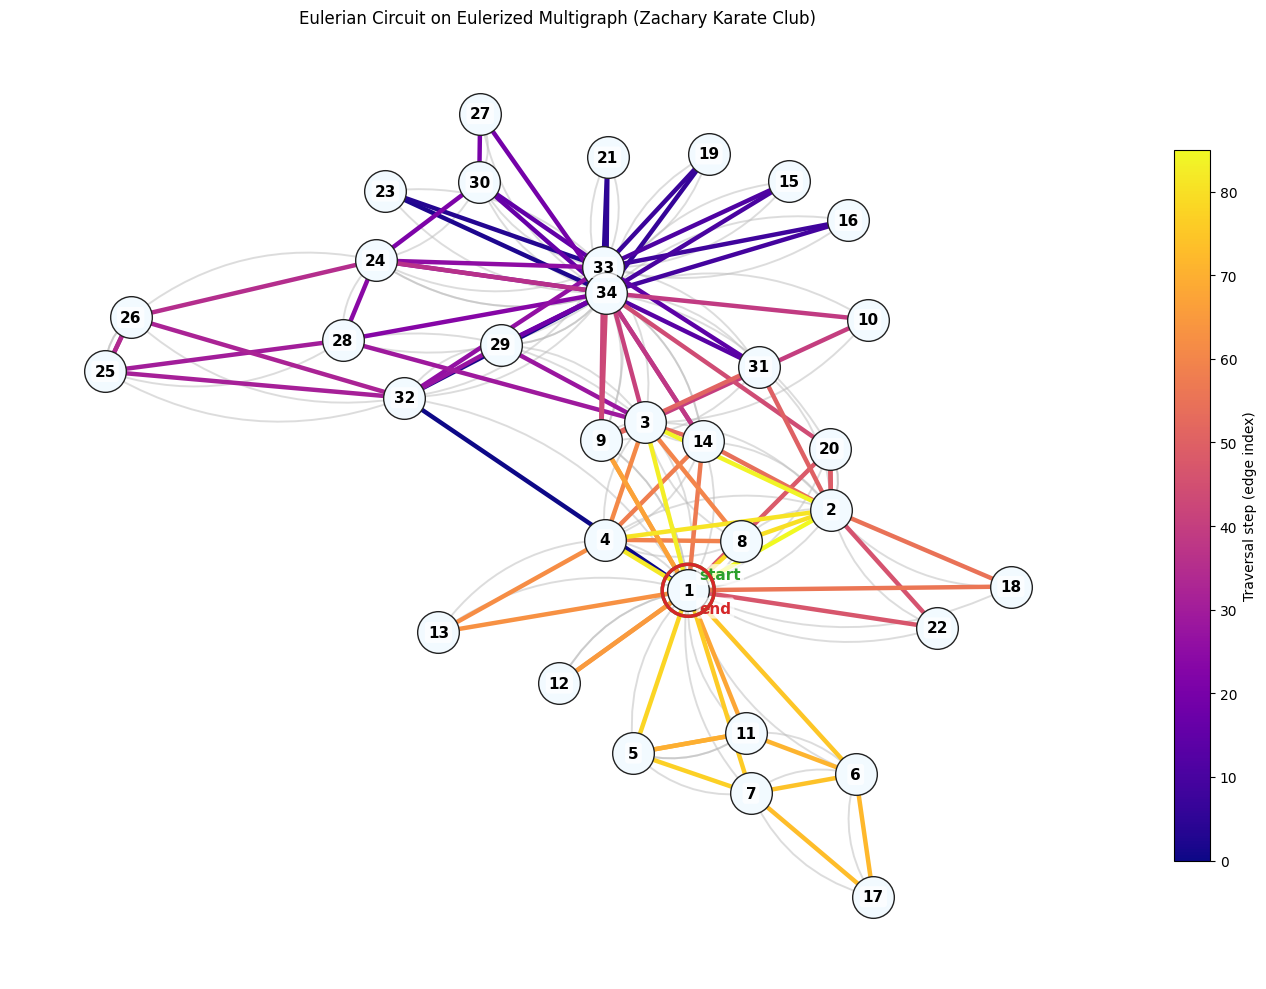

In [19]:
circuit_walk = list(nx.eulerian_circuit(H_circuit, keys=H_circuit.is_multigraph()))
draw_euler_walk(
    H_circuit, circuit_walk,
    title="Eulerian Circuit on Eulerized Multigraph (Zachary Karate Club)",
    spread=3.8, seed=10, base_connection_rad=0.24
)

/tmp/ipykernel_40713/2036448672.py:67: UserWarning: 

The connectionstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default values.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(


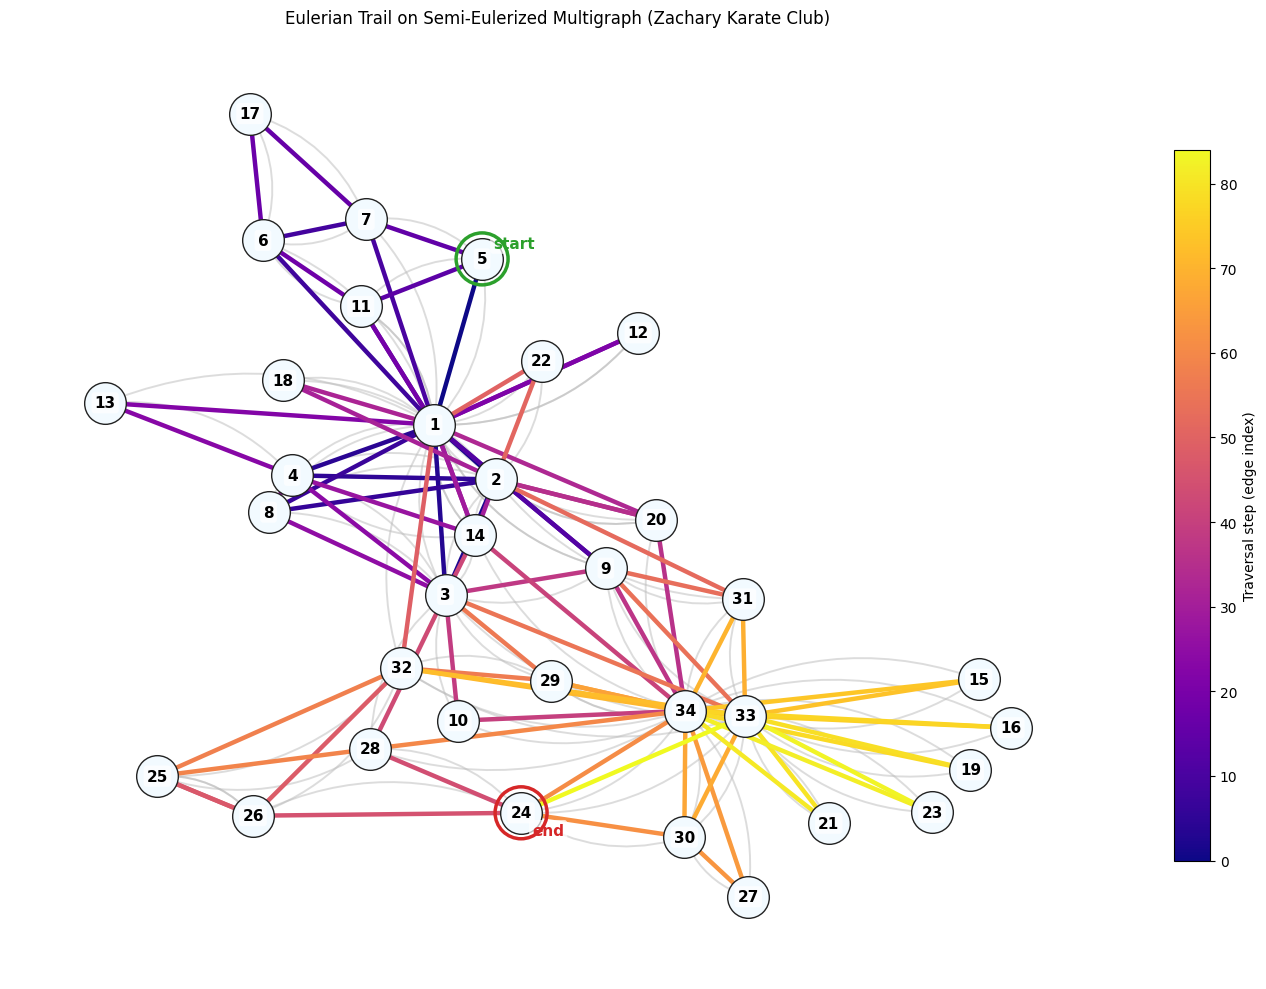

In [20]:
trail_walk = list(nx.eulerian_path(M_trail, keys=M_trail.is_multigraph()))
draw_euler_walk(
    M_trail, trail_walk,
    title="Eulerian Trail on Semi-Eulerized Multigraph (Zachary Karate Club)",
    spread=3.8, seed=11, base_connection_rad=0.24
)